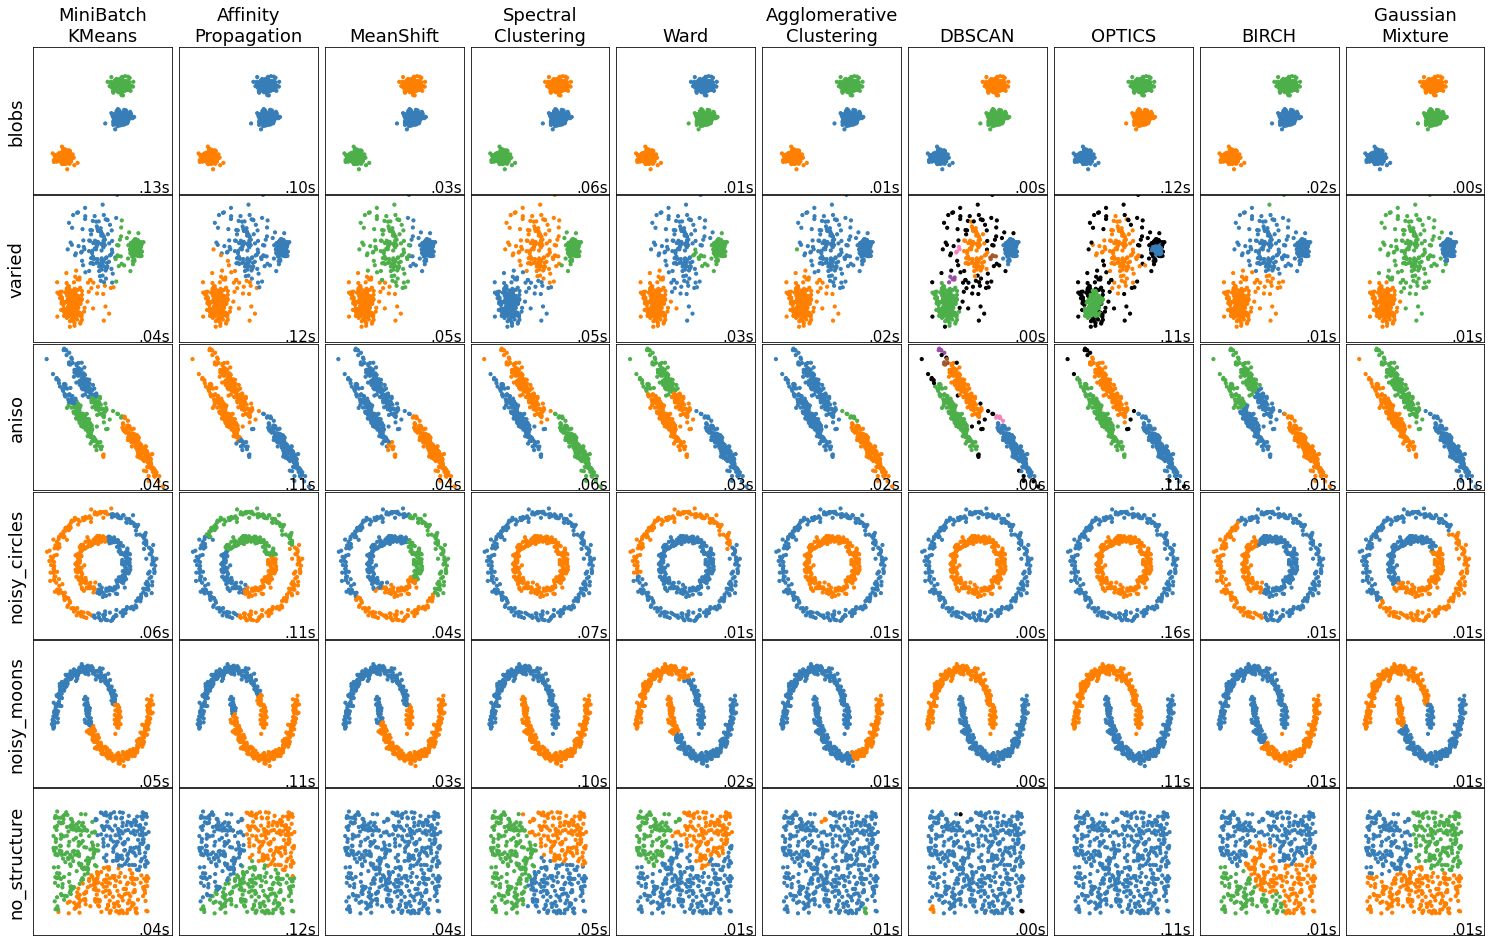

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
warnings.filterwarnings('ignore')

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets_name = ['blobs', 'varied', 'aniso', 'noisy_circles', 'noisy_moons', 'no_structure']

datasets = [
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        if name=="MiniBatch\nKMeans":
            plt.ylabel(datasets_name[i_dataset], fontsize=18.0)
        
        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import radviz

#Nhập dữ liệu
dat = pd.read_csv('IRIS.csv')
dat


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
#Chia dữ liệu thành 2 bộ train và test
from sklearn.model_selection import train_test_split

X = dat.drop(columns='species',axis=1)
Y = dat['species'] #Label --> ko dùng

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.3) # 30% dữ liệu là test
print(X_train.shape)  # 105 records out of 150 will be the training data
print(X_test.shape)   #  45 records out of 150 will be the testing  data


(105, 4)
(45, 4)


In [4]:
def plot_data(X, Y, TYPE):
    temp = pd.concat([X, Y], axis=1) #Tạo df từ X và Y
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    sns.scatterplot(data=temp, x='petal_length', y='petal_width', hue='species', s=50, ax=ax[0])\
    .set(title='scatter');
    radviz(temp, "species", ax=ax[1], color = ['blue', 'green', 'red'])\
    .set_title('radviz-3-kinds')
    # radviz(temp[temp['species'] != 'Iris-setosa'], "species", ax=ax[2], color = ['green', 'red']).set_title('radviz-2-kind')
    plt.suptitle(TYPE)
    plt.tight_layout()
    plt.show()


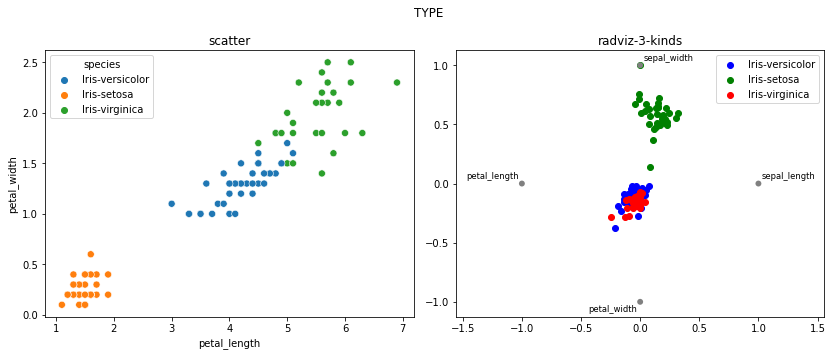

In [5]:
plot_data(X_train, Y_train, "TYPE")

In [6]:
#Khai báo thư viện
from sklearn.cluster import KMeans
# from sklearn.cluster import MiniBatchKMeans

#Tạo model
kmeans = KMeans(n_clusters=3)

start = time.time()
#Học (train)
kmeans.fit(X_train)
print(time.time()-start) #Tính thời gian

#Kết quả của train
Y_learn = kmeans.labels_ #numpy array
Y_learn = pd.Series(Y_learn, index=X_train.index) #chuyển từ np array -> pandas series
Y_learn.name = 'species' #đổi tên series
# Y_learn


0.02448582649230957


In [7]:
#Tâm của nhóm (trường hợp này không gian 4 chiều)
kmeans.cluster_centers_


array([[5.79130435, 2.71304348, 4.29347826, 1.3826087 ],
       [5.00857143, 3.42571429, 1.48      , 0.24571429],
       [6.80833333, 3.02083333, 5.6125    , 1.9625    ]])

In [8]:
#Dự đoán kết quả từ dữ liệu X_test
Y_pred = kmeans.predict(X_test)
Y_pred = pd.Series(Y_pred, index=X_test.index)
Y_pred.name = 'species'
# Y_pred


In [9]:
#Phương pháp rand_score [-1,1]
print(metrics.rand_score(Y_train, Y_learn))
print(metrics.rand_score(Y_test, Y_pred))


NameError: name 'metrics' is not defined

In [ ]:
#Phương pháp adjusted_rand_score, [0,1]
print(metrics.adjusted_rand_score(Y_train, Y_learn))
print(metrics.adjusted_rand_score(Y_test, Y_pred))


In [ ]:
#Phương pháp adjusted_mutual_info_score, [0,1]
print(metrics.adjusted_mutual_info_score(Y_train, Y_learn))
print(metrics.adjusted_mutual_info_score(Y_test, Y_pred))


In [ ]:
#Phương pháp normalized_mutual_info_score, [0,1]
print(metrics.normalized_mutual_info_score(Y_train, Y_learn))
print(metrics.normalized_mutual_info_score(Y_test, Y_pred))


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import time

dat_train = pd.read_csv("mobile train.csv")

X_train = dat_train.drop(columns='price_range',axis=1)
Y_train = dat_train["price_range"]

dat_test = pd.read_csv("mobile test.csv")
X_test = dat_test.drop(columns='id',axis=1)

kmeans = KMeans(n_clusters=4)

start = time.time()

kmeans.fit(X_train)
print("thời gian train",time.time()-start) 

Y_learn = kmeans.labels_ 
Y_learn = pd.Series(Y_learn, index=X_train.index)
Y_learn.name = 'price_range' 


Y_pred = kmeans.predict(X_test)
Y_pred = pd.Series(Y_pred, index=X_test.index)
Y_pred.name = 'price_range'

#Phương pháp rand_score
print("Phương pháp rand_score", metrics.rand_score(Y_train, Y_learn))

#Phương pháp adjusted_rand_score
print("Phương pháp adjusted_rand_score",metrics.adjusted_rand_score(Y_train, Y_learn))

thời gian train 0.14304041862487793
Phương pháp rand_score 0.7965217608804402
Phương pháp adjusted_rand_score 0.46599047442633007


In [2]:

from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4)

start = time.time()
kmeans.fit(X_train)
print("thời gian train", time.time()-start)

Y_learn = kmeans.labels_
Y_learn = pd.Series(Y_learn, index=X_train.index)
Y_learn.name = 'price_range'


Y_pred = kmeans.predict(X_test)
Y_pred = pd.Series(Y_pred, index=X_test.index)
Y_pred.name = 'price_range'

#Phương pháp rand_score
print("Phương pháp rand_score", metrics.rand_score(Y_train, Y_learn))

#Phương pháp adjusted_rand_score
print("Phương pháp adjusted_rand_score",metrics.adjusted_rand_score(Y_train, Y_learn))

thời gian train 0.08128595352172852
Phương pháp rand_score 0.7834117058529264
Phương pháp adjusted_rand_score 0.428392085258945


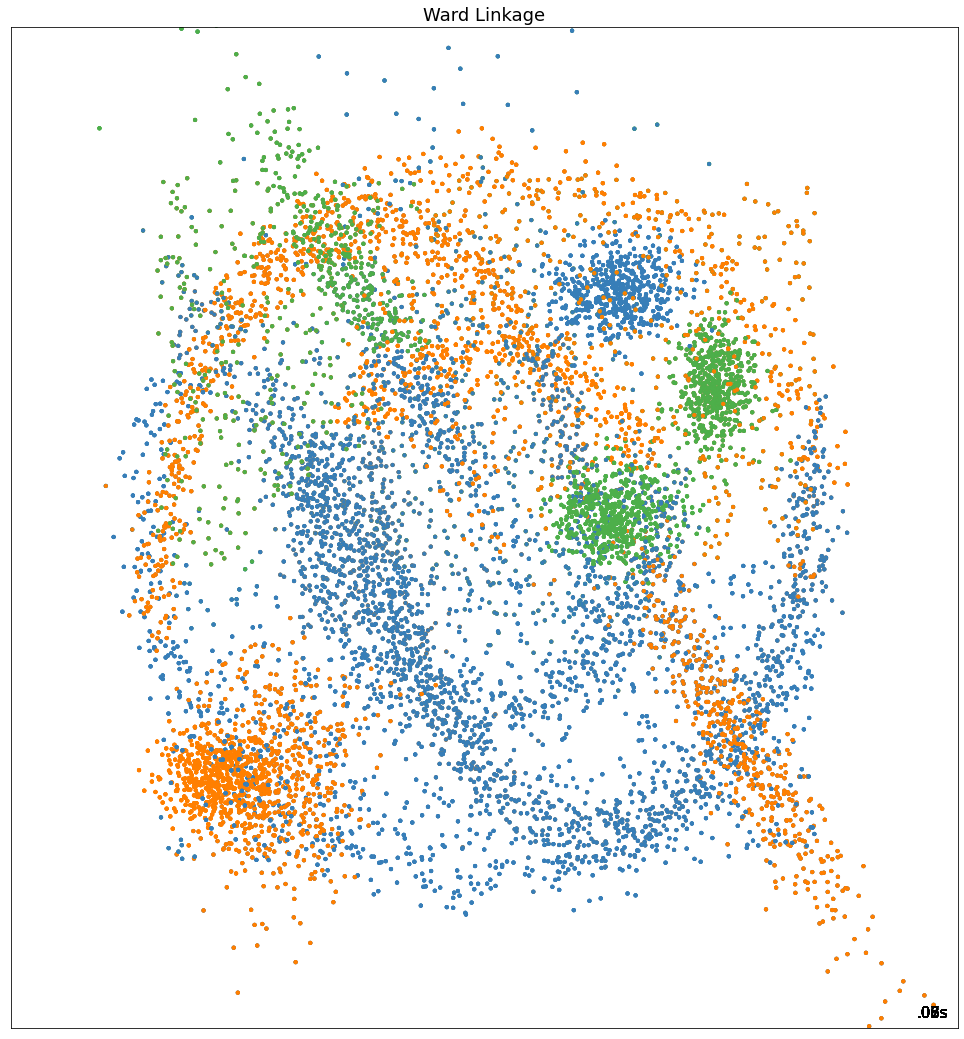

In [5]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="single"
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
            plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import radviz

#Nhập dữ liệu
dat = pd.read_csv('IRIS.csv')
dat
#Chia dữ liệu thành 2 bộ train và test
from sklearn.model_selection import train_test_split

X = dat.drop(columns='species',axis=1)
Y = dat['species'] #Label --> ko dùng

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.3) # 30% dữ liệu là test
print(X_train.shape)  # 105 records out of 150 will be the training data
print(X_test.shape)   #  45 records out of 150 will be the testing  data

(105, 4)
(45, 4)


In [9]:
#Khai báo thư viện
from sklearn.cluster import AgglomerativeClustering

# linkage = ['ward', 'complete', 'average', 'single']

#Tạo model
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")

start = time.time()
#Train
cluster.fit(X_train)
print('Thời gian học:', time.time()-start, 's')


Thời gian học: 0.005590200424194336 s


In [12]:
#Lấy kết quả
Y_pred = cluster.labels_
Y_pred = pd.Series(Y_pred, index=X_train.index)
Y_pred.name = 'species'